In [ ]:
!pip install pycaret

     |████████████████████████████████| 264 kB 21.7 MB/s 
     |████████████████████████████████| 2.0 MB 9.6 MB/s 
     |████████████████████████████████| 167 kB 33.4 MB/s 
     |████████████████████████████████| 1.3 MB 32.4 MB/s 
     |████████████████████████████████| 271 kB 37.8 MB/s 
     |████████████████████████████████| 6.8 MB 23.4 MB/s 
     |████████████████████████████████| 1.7 MB 41.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 14.6 MB 87 kB/s 
     |████████████████████████████████| 248 kB 74.1 MB/s 
     |████████████████████████████████| 111 kB 72.1 MB/s 
     |████████████████████████████████| 80 kB 8.6 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 10.1 MB 36.3 MB/s 
     |████████████████████████████████| 62 kB 868 kB/s 
     |████████████████████

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split,ParameterGrid

from sklearn.pipeline import FeatureUnion
import math
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv( '/content/gdrive/My Drive/Covid-19-X-ray-data/metadata.csv')
df.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,22-Jan-20,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,25-Jan-20,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,27-Jan-20,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,28-Jan-20,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,25-Jan-20,"Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [ ]:
df.shape

(334, 29)

In [ ]:
df.columns

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'survival', 'intubated',
       'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2',
       'extubated', 'temperature', 'pO2_saturation', 'leukocyte_count',
       'neutrophil_count', 'lymphocyte_count', 'view', 'modality', 'date',
       'location', 'folder', 'filename', 'doi', 'url', 'license',
       'clinical_notes', 'other_notes', 'Unnamed: 28'],
      dtype='object')

In [ ]:
txt_data = df[['finding', 'survival', 'clinical_notes', 'other_notes', 'Unnamed: 28' ]]

In [ ]:
txt_data.shape

(334, 5)

In [ ]:
def count_na(txt_data, col):
    return txt_data[col].isna().sum()

In [ ]:
txt_data['finding'] = txt_data['finding'].astype('category')

In [ ]:
txt_data['label'] = txt_data['finding'].cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
finding_to_label = {}
label_to_finding = {}
for _,row in txt_data.iterrows():
  finding_to_label[row['finding']] = row['label']
  label_to_finding[row['label']] = row['finding']

In [ ]:
finding_to_label

{'COVID-19': 0,
 'COVID-19, ARDS': 1,
 'Pneumocystis': 2,
 'SARS': 3,
 'Streptococcus': 4}

In [ ]:
label_to_finding

{0: 'COVID-19',
 1: 'COVID-19, ARDS',
 2: 'Pneumocystis',
 3: 'SARS',
 4: 'Streptococcus'}

In [ ]:
txt_data['clinical_notes'] = txt_data['clinical_notes'].fillna("")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
txt_data['clinical_notes'].values

array(['On January 22, 2020, a 65-year-old man with a history of hypertension, type 2 diabetes, coronary heart disease for which a stent had been implanted, and lung cancer was admitted to the emergency department of Cho Ray Hospital, the referral hospital in Ho Chi Minh City, for low-grade fever and fatigue. He had become ill with fever on January 17, a total of 4 days after he and his wife had flown to Hanoi from the Wuchang district in Wuhan, where outbreaks of 2019-nCoV were occurring. He reported that he had not been exposed to a ���������������������������wet market��������������������������� (a market where dead and live animals are sold) in Wuhan. Chest radiographs obtained on admission showed ',
       'On January 22, 2020, a 65-year-old man with a history of hypertension, type 2 diabetes, coronary heart disease for which a stent had been implanted, and lung cancer was admitted to the emergency department of Cho Ray Hospital, the referral hospital in Ho Chi Minh City, for low-

In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(np.array(txt_data['clinical_notes'].values))

In [ ]:
integer_encoded.shape

(334,)

In [ ]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
onehot_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
onehot_encoded.shape

(334, 254)

In [ ]:
# invert first example
inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
print(inverted)

['On January 22, 2020, a 65-year-old man with a history of hypertension, type 2 diabetes, coronary heart disease for which a stent had been implanted, and lung cancer was admitted to the emergency department of Cho Ray Hospital, the referral hospital in Ho Chi Minh City, for low-grade fever and fatigue. He had become ill with fever on January 17, a total of 4 days after he and his wife had flown to Hanoi from the Wuchang district in Wuhan, where outbreaks of 2019-nCoV were occurring. He reported that he had not been exposed to a ���������������������������wet market��������������������������� (a market where dead and live animals are sold) in Wuhan. Chest radiographs obtained on admission showed ']


In [ ]:
X_clinical_notes = onehot_encoded
X_clinical_notes.shape

(334, 254)

In [ ]:
Y = txt_data['label'].values
Y.shape

(334,)

In [ ]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 4, 4, 4, 4, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
txt_data = txt_data.drop(['finding', 'survival', 'Unnamed: 28'], axis = 1)
txt_data.head()

,clinical_notes,other_notes,label
0,"On January 22, 2020, a 65-year-old man with a ...",NaN,0
1,"On January 22, 2020, a 65-year-old man with a ...",NaN,0
2,"On January 22, 2020, a 65-year-old man with a ...",NaN,0
3,"On January 22, 2020, a 65-year-old man with a ...",NaN,0
4,diffuse infiltrates in the bilateral lower lungs,NaN,0


In [ ]:
from pycaret.classification import *
exp2=setup(txt_data, target= 'label', pca = True, pca_method='incremental')

,Description,Value
0,session_id,654
1,Target,label
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(334, 3)"
5,Missing Values,True
6,Numeric Features,0
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8241,0.4494,0.2050,0.6793,0.7447,0.0000,0.0000,0.325
svm,SVM - Linear Kernel,0.8241,0.0000,0.2050,0.6793,0.7447,0.0000,0.0000,0.065
ridge,Ridge Classifier,0.8241,0.0000,0.2050,0.6793,0.7447,0.0000,0.0000,0.017
ada,Ada Boost Classifier,0.8241,0.5222,0.2050,0.6793,0.7447,0.0000,0.0000,0.098
lda,Linear Discriminant Analysis,0.8241,0.4460,0.2050,0.6793,0.7447,0.0000,0.0000,0.017
lightgbm,Light Gradient Boosting Machine,0.8158,0.5977,0.2598,0.6987,0.7523,0.0757,0.0792,0.106
dt,Decision Tree Classifier,0.8154,0.5903,0.2029,0.6780,0.7403,-0.0091,-0.0118,0.019
rf,Random Forest Classifier,0.8154,0.5928,0.2029,0.6780,0.7403,-0.0091,-0.0118,0.467
gbc,Gradient Boosting Classifier,0.8154,0.5915,0.2029,0.6780,0.7403,-0.0091,-0.0118,0.320
et,Extra Trees Classifier,0.8154,0.5860,0.2029,0.6780,0.7403,-0.0091,-0.0118,0.446


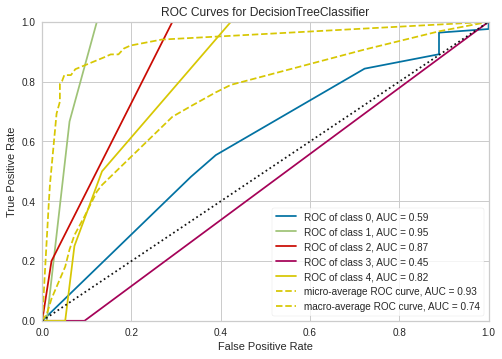

In [ ]:
dt=create_model('dt')
tuned_dt = tune_model(dt)
plot_model(dt)

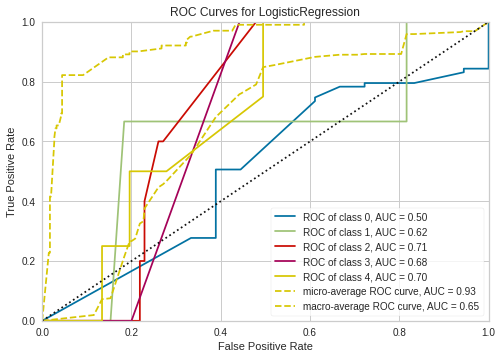

In [ ]:
lr=create_model('lr')
tuned_lr = tune_model(lr)
plot_model(lr)

In [ ]:
evaluate_model(tuned_dt)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
svm=create_model('svm')
tuned_svm = tune_model(svm)
#plot_model(svm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8333,0.0,0.200,0.6944,0.7576,0.0,0.0
1,0.8333,0.0,0.200,0.6944,0.7576,0.0,0.0
2,0.7917,0.0,0.200,0.6267,0.6996,0.0,0.0
3,0.8261,0.0,0.250,0.6824,0.7474,0.0,0.0
4,0.8261,0.0,0.200,0.6824,0.7474,0.0,0.0
5,0.8261,0.0,0.200,0.6824,0.7474,0.0,0.0
6,0.8261,0.0,0.200,0.6824,0.7474,0.0,0.0
7,0.8261,0.0,0.200,0.6824,0.7474,0.0,0.0
8,0.8261,0.0,0.200,0.6824,0.7474,0.0,0.0
9,0.8261,0.0,0.200,0.6824,0.7474,0.0,0.0


In [ ]:
evaluate_model(tuned_svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…